In [3]:
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
import pyhsmm

import autoregressive.models as models
import autoregressive.distributions as distributions


In [5]:
path_to_file5sec = "/media/sf_VBox_Shared/London/accelerometer_5second/merged/__016563_2014-08-08 12-02-19.bin_day1.csv"
day1_5sec = pd.read_csv(path_to_file5sec)

In [6]:
day1_5sec = day1_5sec.set_index('timestamp')
day1_5sec.index = pd.to_datetime(day1_5sec.index)
print(min(day1_5sec.index))
print(max(day1_5sec.index))
day1_5sec.head()

2014-08-01 04:00:00
2014-08-02 03:59:55


,acceleration,anglex,angley,anglez,invalid,Activity
timestamp,,,,,,
2014-08-01 04:00:00,0.014778,27.403869,39.648207,-38.117174,0,NaN
2014-08-01 04:00:05,0.014978,27.407743,39.603882,-38.158723,0,Sleepingandresting(includingsickinbed)
2014-08-01 04:00:10,0.013872,27.428900,39.538962,-38.206537,0,Sleepingandresting(includingsickinbed)
2014-08-01 04:00:15,0.015469,27.417167,39.553611,-38.201570,0,Sleepingandresting(includingsickinbed)
2014-08-01 04:00:20,0.014622,27.420342,39.680349,-38.070763,0,Sleepingandresting(includingsickinbed)


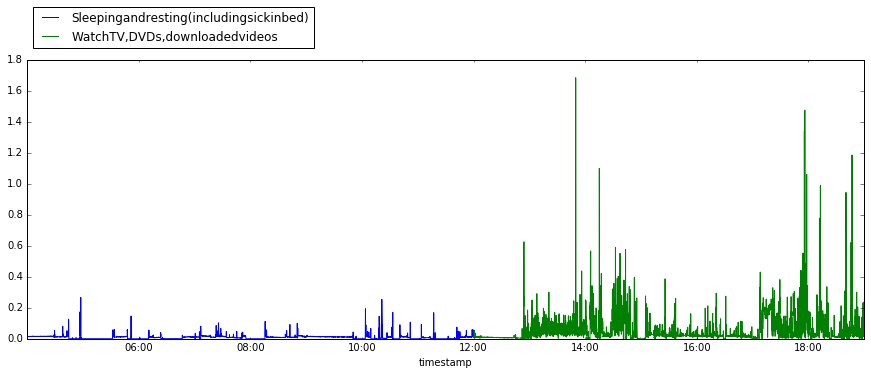

In [7]:
byAct = day1_5sec.groupby('Activity')
fig, ax = plt.subplots(figsize=(15,5))
for act,dfa in byAct:
    dfa['acceleration'].plot(label=act)
legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3);

In [8]:
day1_5sec.groupby('Activity').count()

,acceleration,anglex,angley,anglez,invalid
Activity,,,,,
Sleepingandresting(includingsickinbed),5759,5759,5759,5759,5759
"WatchTV,DVDs,downloadedvideos",5039,5039,5039,5039,5039


In [32]:
X = np.column_stack([day1_5sec.acceleration, day1_5sec.anglex, day1_5sec.angley, day1_5sec.anglez])
column_names = day1_5sec.columns[0:4]
print(column_names)
print(X.shape)

Index([u'acceleration', u'anglex', u'angley', u'anglez'], dtype='object')
(17280, 4)


In [42]:
#Other testdataset
As = [0.99*np.hstack((-np.eye(2),2*np.eye(2))),
        np.array([[np.cos(np.pi/6),-np.sin(np.pi/6)],[np.sin(np.pi/6),np.cos(np.pi/6)]]).dot(np.hstack((-np.eye(2),np.eye(2)))) + np.hstack((np.zeros((2,2)),np.eye(2))),
        np.array([[np.cos(-np.pi/6),-np.sin(-np.pi/6)],[np.sin(-np.pi/6),np.cos(-np.pi/6)]]).dot(np.hstack((-np.eye(2),np.eye(2)))) + np.hstack((np.zeros((2,2)),np.eye(2)))]
print(len(As))
truemodel = models.ARHSMM(
        alpha=4.,init_state_concentration=4.,
        obs_distns=[distributions.AutoRegression(A=A,sigma=np.eye(2)) for A in As],
        dur_distns=[pyhsmm.basic.distributions.PoissonDuration(alpha_0=4*25,beta_0=4)
            for state in range(len(As))],
        )

data, labels = truemodel.generate(500)
print(data.shape)
data

3
(502, 2)


array([[   6.98085874,    3.6741895 ],
       [   3.9660235 ,   -1.687813  ],
       [  -0.90982549,   -7.57536591],
       ..., 
       [ -50.57565895, -227.64809239],
       [ -40.50847991, -223.49585913],
       [ -30.08617494, -225.61708564]])

In [45]:
#Parameters for SAR
Nmax = 5
affine = True
order = 4
dim = X.shape[1]

In [43]:
?distributions.AutoRegression

In [44]:
#The observations have a autogression-distribution
obs_distns = [distributions.AutoRegression(
    nu_0=3, S_0=np.eye(5), M_0=np.zeros((2,4+affine)),
    K_0=np.eye(4+affine), affine=affine) 
        ) for state in range(Nmax)]
obs_distns

AssertionError: Input dimensions not consistent

In [ ]:
#The distribution of the durations can alsobe modeled, (then use non-stationary model) but let's skip that for now

In [36]:
# What is alpha? - should infer it, as in the example examples/concentration_resampling.py
model = models.ARHMM(alpha=4., obs_distns=obs_distns, init_state_distn='uniform')

In [37]:
model.add_data(X)

In [38]:
#resample
for itr in xrange(100):
    model.resample_model()

ValueError: operands could not be broadcast together with shapes (2,5) (2,107) 

In [27]:
model.plot?

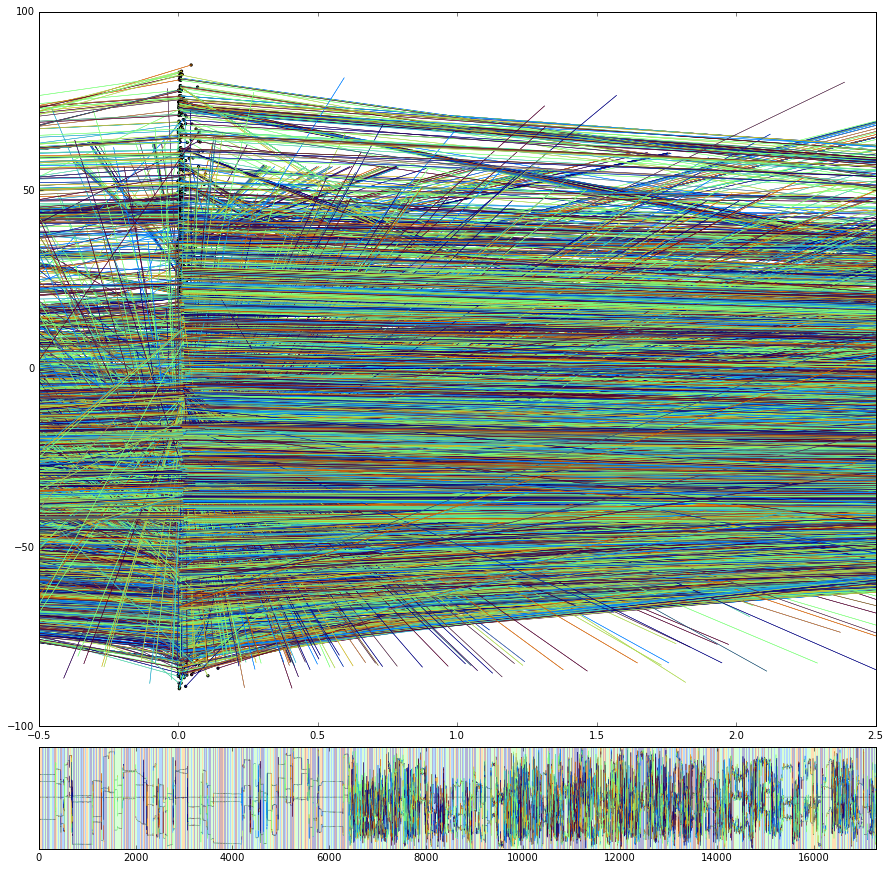

In [28]:
fig = plt.figure(figsize(15,15))
plt.clf()
model.plot(fig)

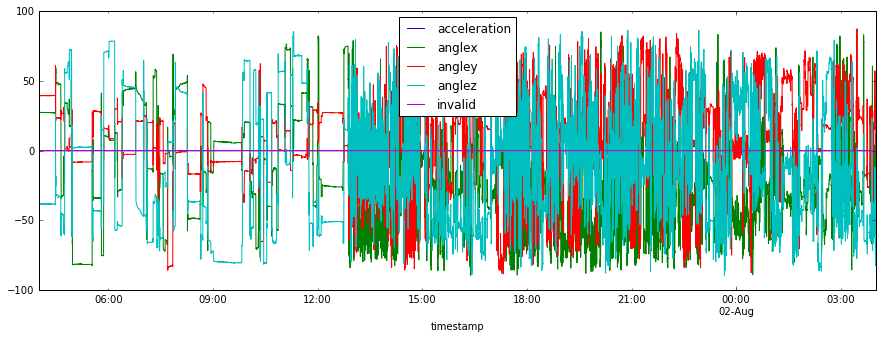

In [10]:
day1_5sec.plot(figsize=(15,5))
plt.show()

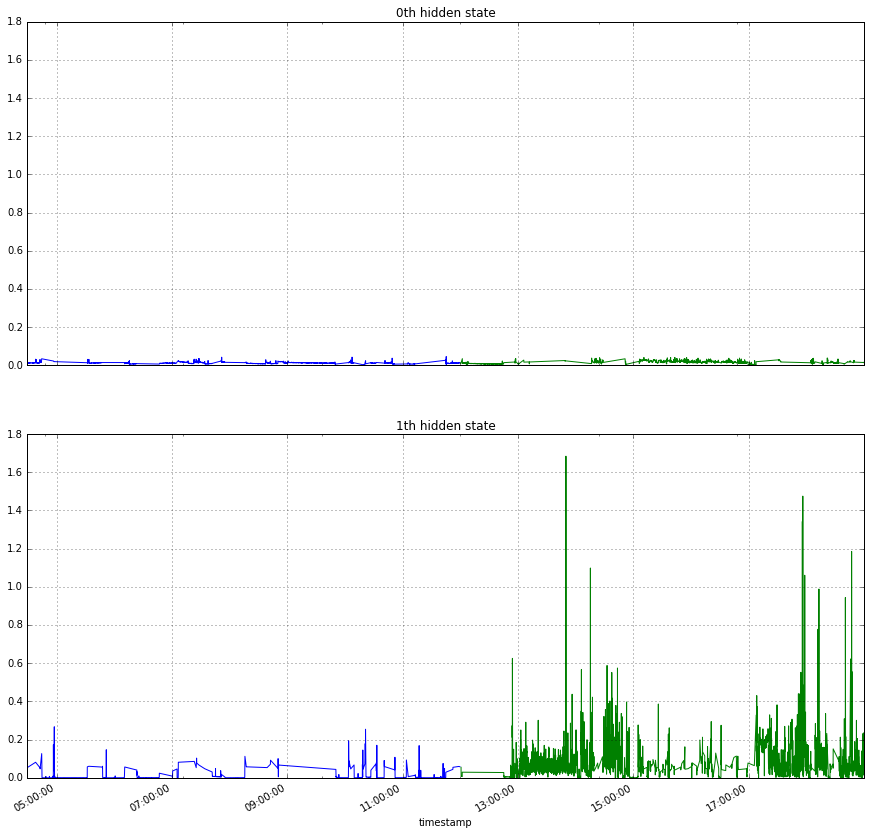

In [12]:
fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True, figsize=(15,15))
colours = cm.rainbow(np.linspace(0, 1, model.n_components))
for i, (ax, colour) in enumerate(zip(axs, colours)):
    # Use fancy indexing to plot data in each state.
    mask = hidden_states == i
    byAct = day1_5sec[mask].groupby('Activity')
    for act,dfa in byAct:
        dfa['acceleration'].plot(ax=ax, label=act)
    #ax.plot(plotdata, ".-")
    ax.set_title("{0}th hidden state".format(i))

    # Format the ticks.
    #ax.xaxis.set_major_locator(YearLocator())
    #ax.xaxis.set_minor_locator(MonthLocator())

    ax.grid(True)

plt.show()

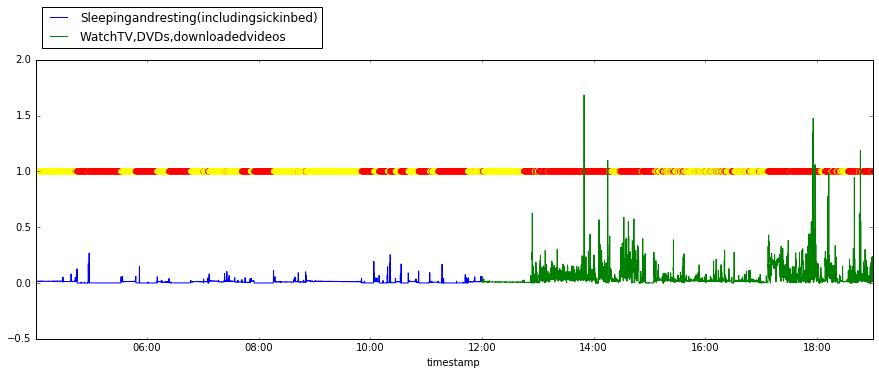

In [13]:
fig = figure(figsize=(15,5))
byAct = day1_5sec.groupby('Activity')
fig, ax = plt.subplots(figsize=(15,5))
for act,dfa in byAct:
    dfa['acceleration'].plot(label=act)
legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3);
colormap = {0: (1,1,0), 1: (1,0,0), 2: (0,1,0), 3: (0,0,1)}
state_colors = [colormap[i] for i in hidden_states]
plt.scatter(day1_5sec.index, np.ones_like(hidden_states), color=state_colors)
#plt.xlim(min(), max(byAct.index))

In [138]:
model.transmat_

array([[ 0.95741117,  0.04258883],
       [ 0.03704744,  0.96295256]])

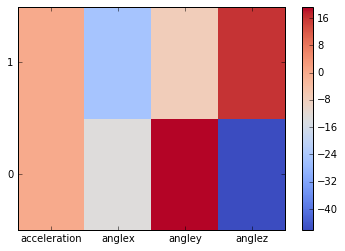

In [139]:
plotdata = model.means_

fig, ax = plt.subplots()
colorplot = ax.pcolor(plotdata, cmap='coolwarm',)
ax.set_xticks(np.arange(plotdata.shape[1])+0.5, minor=False)
ax.set_yticks(np.arange(plotdata.shape[0])+0.5, minor=False)
ax.set_xticklabels(column_names, minor=False)
ax.set_yticklabels(range(plotdata.shape[0]), minor=False)
plt.colorbar(colorplot)

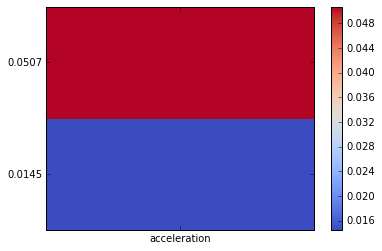

In [140]:
plotdata = model.means_[:,0][:,np.newaxis]
grouplabels = ["{:.3}".format(x) for x in plotdata[:,0]]
fig, ax = plt.subplots()
colorplot = ax.pcolor(plotdata, cmap='coolwarm',)
ax.set_xticks(np.arange(plotdata.shape[1])+0.5, minor=False)
ax.set_yticks(np.arange(plotdata.shape[0])+0.5, minor=False)
ax.set_xticklabels(column_names, minor=False)
ax.set_yticklabels(grouplabels, minor=False)
fig.colorbar(colorplot)
print()

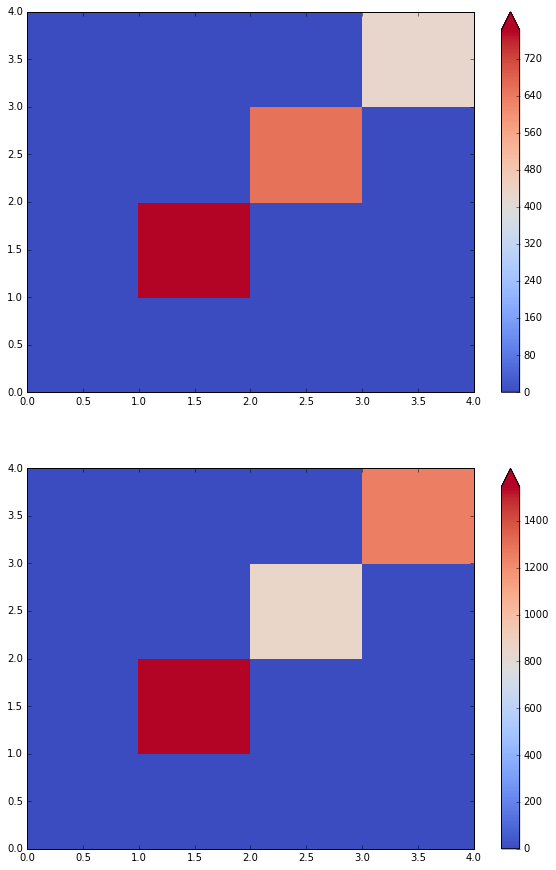

In [141]:
fig, axs = plt.subplots(nrows=model.n_components, ncols=1,  figsize = (10, 15))
for i in range(nr_states):
    im = axs[i].pcolor(model.covars_[i], cmap='coolwarm',)
    fig.colorbar(im, ax = axs[i], extend='max')
#colorbar()
show()

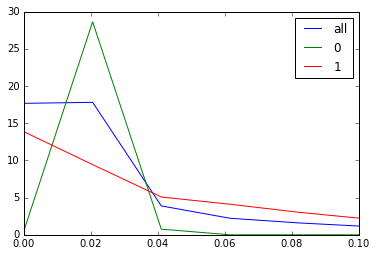

In [142]:
from scipy.stats.kde import gaussian_kde

variable = "acceleration"

fig, ax = subplots()
#day1_5sec.hist(variable, bins=100)
vals = day1_5sec[variable]
kde = gaussian_kde(vals)
d = np.linspace(min(vals), max(vals), 100)
p = plot(d, kde(d), label="all")

for i in range(nr_states):
    mask = hidden_states == i
    kde = gaussian_kde(vals[mask])
    plot(d, kde(d), label=str(i))
    #p = plt.hist(day1_5sec[mask][variable], bins=100)
ax.set_xlim(0,0.1)
legend()
show()

In [143]:
column_names

Index(['acceleration', 'anglex', 'angley', 'anglez'], dtype='object')